####Install libraries

In [1]:
!pip install shap==0.44.1 -q

In [2]:
import warnings
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.stats import skew
from shap import Explanation, Explainer, summary_plot, dependence_plot, decision_plot
from shap.plots import waterfall, force
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

warnings.filterwarnings('ignore')
shap.initjs()

####Load data

In [3]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/MCS/CSI5155/Assignment2/heart.csv")

In [5]:
# rename the column names
df = df.rename(columns = {
    "cp" : "chest_pain_type",
    "trtbps" : "resting_bp",
    "chol" : "cholestrol",
    "fbs" : "fasting_sugar",
    "restecg" : "rest_ecg",
    "thalachh" : "max_heart_rate",
    "exng" : "exercise_angina",
    "slp" : "slope_st_segment",
    "oldpeak" : "st_depr_exercise",
    "caa" : "major_vessels",
    "thall": "thalassemia",
    "output": "chance_of_heart_attack",
  })

1. age: age in years
2. sex: sex (1 = male, 0 = female)
3. chest_pain_type: chest pain type (0 = asymptomatic, 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain)
4. resting_bp: resting blood pressure (in mm Hg on admission to the hospital)
cholestrol: serum cholestoral in mg/dl
5. fasting_sugar: fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
6. rest_ecg: resting electrocardiographic results (0 = hypertrophy, 1 = normal, 2 = having ST-T wave abnormality)
7. max_heart_rate: maximum heart rate achieved
8. exercise_angina: exercise induced angina (1 = yes, 0 = no)
9. st_depr_exercise: ST depression induced by exercise relative to rest
10. slope_st_segment: the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)
11. major_vessels: number of major vessels (0-3) colored by flourosopy
12. thalassemia: (1 = fixed defect, 2 = normal, 3 = reversable defect)
13. chance_of_heart_attack: [the predicted attribute] diagnosis of heart disease (angiographic disease status) (Value 0 = less chance of heart disease; Value 1 = more chance of heart disease)


In [6]:
df.head()

age  sex  chest_pain_type  resting_bp  cholestrol  fasting_sugar  rest_ecg  \
0   63    1                3         145         233              1         0   
1   37    1                2         130         250              0         1   
2   41    0                1         130         204              0         0   
3   56    1                1         120         236              0         1   
4   57    0                0         120         354              0         1   

   max_heart_rate  exercise_angina  st_depr_exercise  slope_st_segment  \
0             150                0               2.3                 0   
1             187                0               3.5                 0   
2             172                0               1.4                 2   
3             178                0               0.8                 2   
4             163                1               0.6                 2   

   major_vessels  thalassemia  chance_of_heart_attack  
0              0            1                       1  
1              0            2                       1  
2              0            2                       1  
3              0            2                       1  
4              0            2                       1

In [7]:
df.shape

(303, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     303 non-null    int64  
 1   sex                     303 non-null    int64  
 2   chest_pain_type         303 non-null    int64  
 3   resting_bp              303 non-null    int64  
 4   cholestrol              303 non-null    int64  
 5   fasting_sugar           303 non-null    int64  
 6   rest_ecg                303 non-null    int64  
 7   max_heart_rate          303 non-null    int64  
 8   exercise_angina         303 non-null    int64  
 9   st_depr_exercise        303 non-null    float64
 10  slope_st_segment        303 non-null    int64  
 11  major_vessels           303 non-null    int64  
 12  thalassemia             303 non-null    int64  
 13  chance_of_heart_attack  303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.

#### Clean data

In [9]:
print("Total null values in the data: ", df.isnull().sum().sum(), "\n")

Total null values in the data:  0 



In [10]:
# check for NaN values
df.isna().any()

age                       False
sex                       False
chest_pain_type           False
resting_bp                False
cholestrol                False
fasting_sugar             False
rest_ecg                  False
max_heart_rate            False
exercise_angina           False
st_depr_exercise          False
slope_st_segment          False
major_vessels             False
thalassemia               False
chance_of_heart_attack    False
dtype: bool

In [11]:
print("Number of duplicated rows = ", len(df[df.duplicated()]))
df[df.duplicated()]

Number of duplicated rows =  1


age  sex  chest_pain_type  resting_bp  cholestrol  fasting_sugar  \
164   38    1                2         138         175              0   

     rest_ecg  max_heart_rate  exercise_angina  st_depr_exercise  \
164         1             173                0               0.0   

     slope_st_segment  major_vessels  thalassemia  chance_of_heart_attack  
164                 2              4            2                       1

In [12]:
# drop duplicate rows
df = df.drop_duplicates(keep='first')

In [13]:
df.nunique()

age                        41
sex                         2
chest_pain_type             4
resting_bp                 49
cholestrol                152
fasting_sugar               2
rest_ecg                    3
max_heart_rate             91
exercise_angina             2
st_depr_exercise           40
slope_st_segment            3
major_vessels               5
thalassemia                 4
chance_of_heart_attack      2
dtype: int64

#### Exploratory Data Analysis

In [14]:
cat_cols = ['sex', 'chest_pain_type', 'fasting_sugar', 'rest_ecg', 'exercise_angina', 'slope_st_segment', 'thalassemia', 'chance_of_heart_attack']
num_cols = [col for col in df.columns if col not in cat_cols]

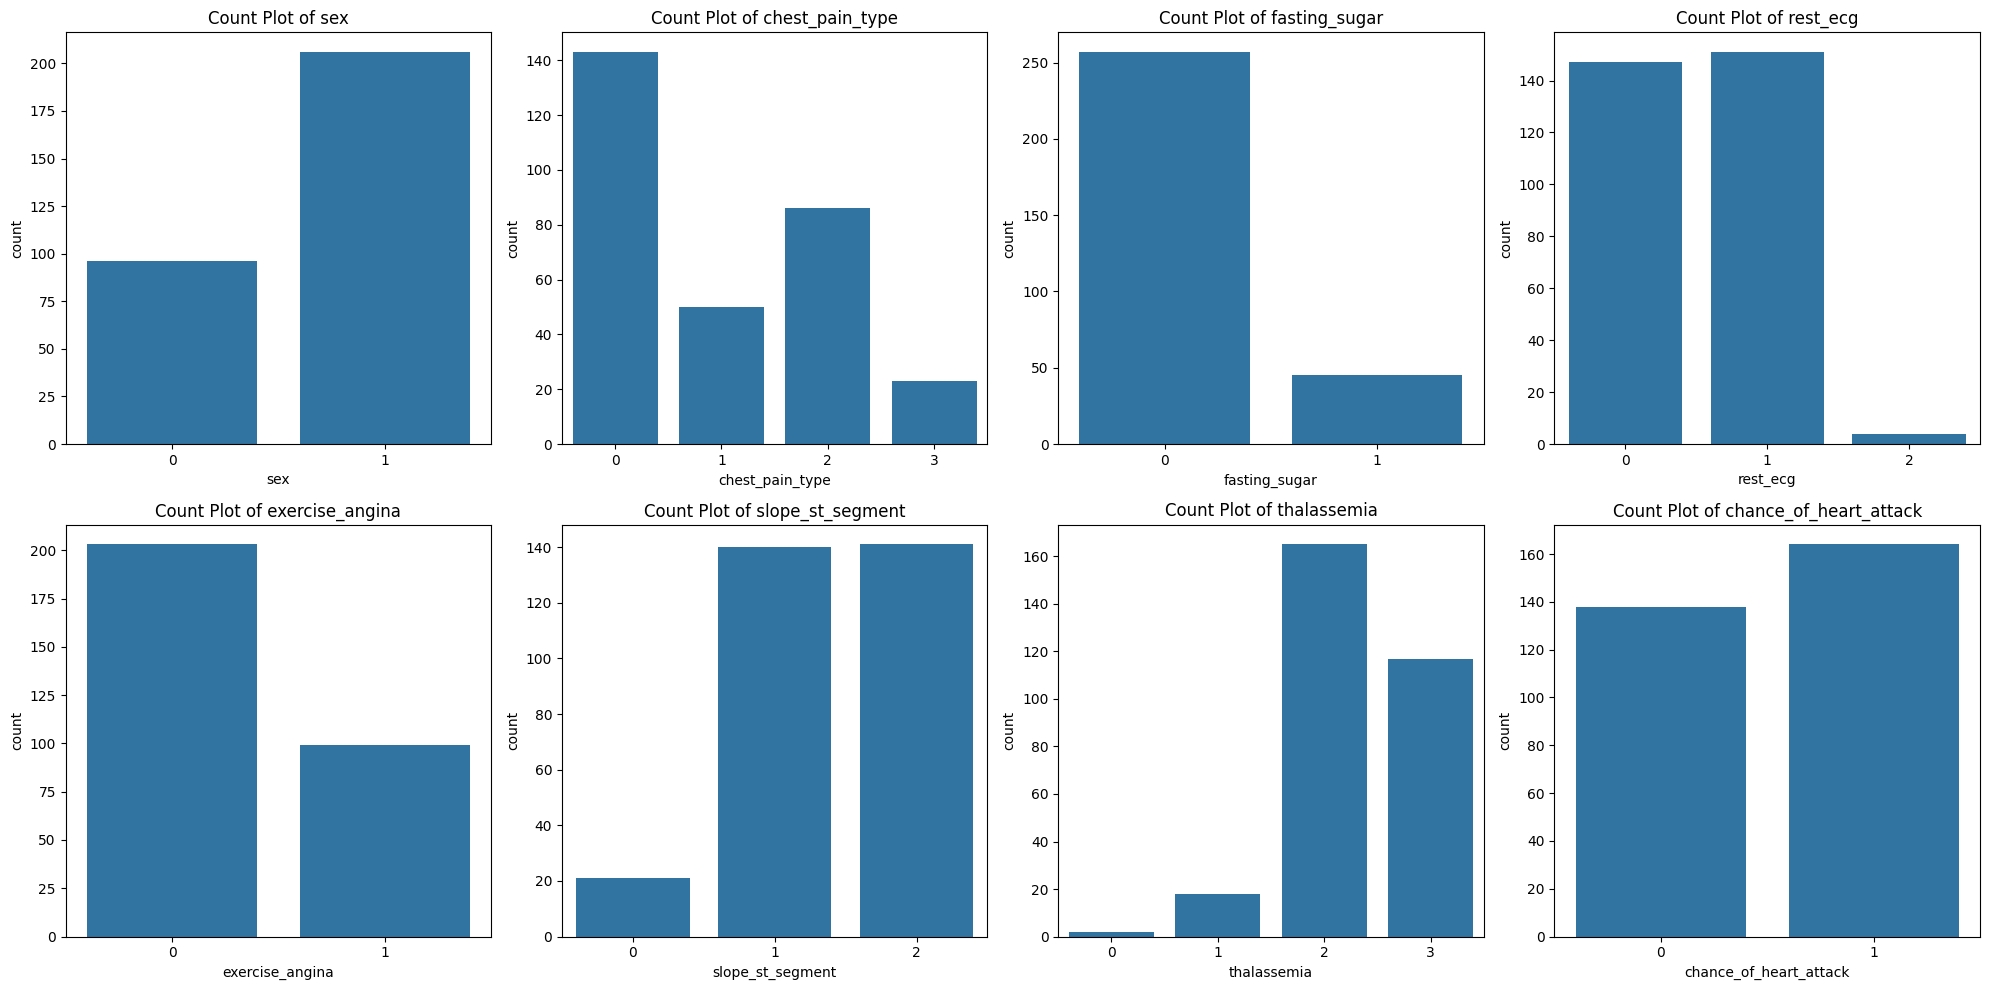

In [15]:
# count plots for categorical columns
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}')

plt.tight_layout()
plt.show()

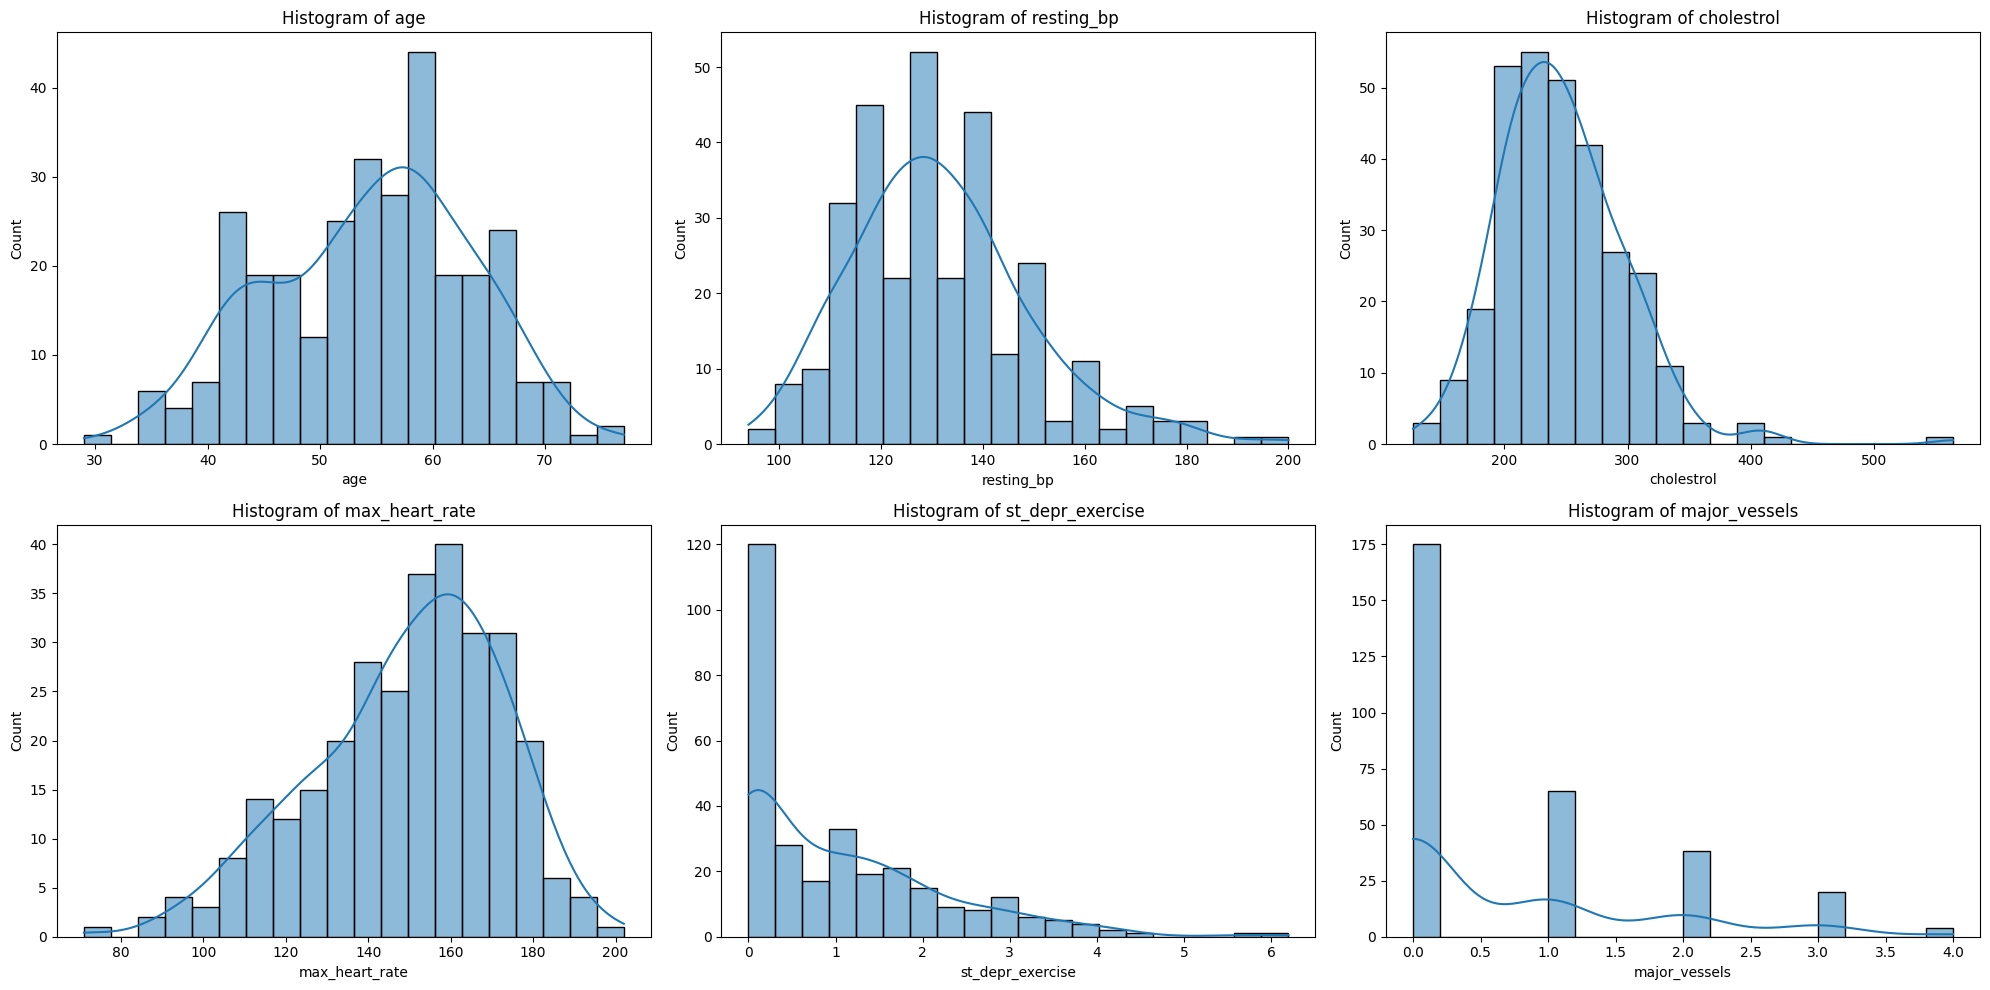

In [16]:
# histograms for the numerical columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.histplot(x=col, data=df, ax=axes[i], bins=20, kde=True)
  axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [17]:
print("Average age by Heart Attack", df.groupby('chance_of_heart_attack')['age'].mean())

Average age by Heart Attack chance_of_heart_attack
0    56.601449
1    52.585366
Name: age, dtype: float64


In [18]:
df[num_cols].describe().T

count        mean        std    min     25%    50%     75%  \
age               302.0   54.420530   9.047970   29.0   48.00   55.5   61.00   
resting_bp        302.0  131.602649  17.563394   94.0  120.00  130.0  140.00   
cholestrol        302.0  246.500000  51.753489  126.0  211.00  240.5  274.75   
max_heart_rate    302.0  149.569536  22.903527   71.0  133.25  152.5  166.00   
st_depr_exercise  302.0    1.043046   1.161452    0.0    0.00    0.8    1.60   
major_vessels     302.0    0.718543   1.006748    0.0    0.00    0.0    1.00   

                    max  
age                77.0  
resting_bp        200.0  
cholestrol        564.0  
max_heart_rate    202.0  
st_depr_exercise    6.2  
major_vessels       4.0

#### Feature Engineering

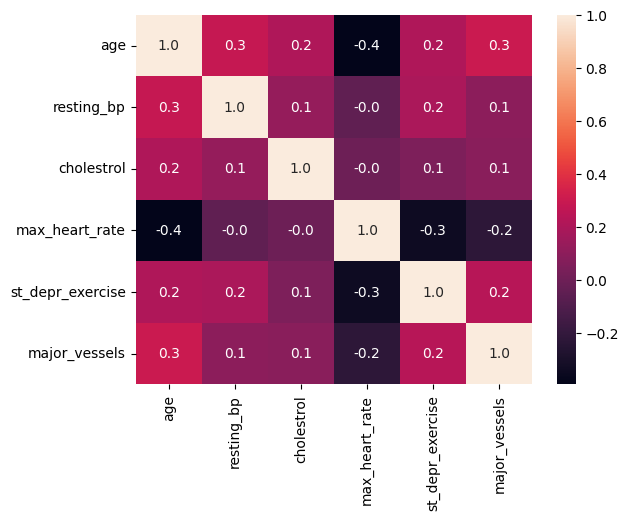

In [19]:
# heatmap of correlation values for numerical columns
sns.heatmap(df[num_cols].corr(), fmt=".1f", annot=True)
plt.show()

In [20]:
# checking skewness of numerical cols
df[num_cols].skew()

age                -0.203743
resting_bp          0.716541
cholestrol          1.147332
max_heart_rate     -0.532671
st_depr_exercise    1.266173
major_vessels       1.295738
dtype: float64

For Tree based Machine Learning Algorithms the best way to go is with Label Encoding. Since, all the categorical columns are already label encoded (like in order 0, 1, 2, 3 ...), so there's not as such need of perform encoding.

In [21]:
y = df.chance_of_heart_attack
X = df.drop('chance_of_heart_attack', axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
X_test.shape

(61, 13)

RobustScaler is robust to outliers. It uses the median and the interquartile range (IQR) instead of the mean and standard deviation. This makes it less sensitive to extreme values in the data.
The median is less affected by outliers compared to the mean, and the IQR is a measure of the spread of the middle 50% of the data, which is less affected by outliers.

In [24]:
# normalise data
scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [25]:
X_train.head()

age  sex  chest_pain_type  resting_bp  cholestrol  fasting_sugar  \
59   0.071429    0                0        -0.1    1.016129              0   
247  0.714286    1                1         1.5    0.096774              0   
289 -0.071429    0                0        -0.1   -0.564516              0   
288  0.071429    1                0        -1.0    1.532258              0   
64   0.142857    1                2         0.5   -0.467742              1   

     rest_ecg  max_heart_rate  exercise_angina  st_depr_exercise  \
59          0         0.21875                0         -0.444444   
247         1        -1.00000                1         -0.444444   
289         2        -0.68750                1          0.666667   
288         1        -0.28125                1          1.222222   
64          0         0.40625                0         -0.444444   

     slope_st_segment  major_vessels  thalassemia  
59                  2            1.0            2  
247                 1            3.0            1  
289                 1            1.0            3  
288                 1            1.0            3  
64                  2            0.0            2

In [26]:
X_test.head()

age  sex  chest_pain_type  resting_bp  cholestrol  fasting_sugar  \
179  0.071429    1                0        1.00    0.580645              0   
197  0.785714    1                0       -0.25    0.225806              1   
285 -0.714286    1                0        0.50    1.145161              0   
194  0.285714    1                2        0.50   -0.887097              0   
188 -0.428571    1                2        0.50   -0.112903              0   

     rest_ecg  max_heart_rate  exercise_angina  st_depr_exercise  \
179         0        -1.25000                1         -0.111111   
197         1         0.34375                0         -0.333333   
285         1        -1.00000                1          0.555556   
194         0         0.09375                0          1.222222   
188         1         0.34375                0         -0.111111   

     slope_st_segment  major_vessels  thalassemia  
179                 1            1.0            1  
197                 1            2.0            3  
285                 1            2.0            3  
194                 1            0.0            2  
188                 1            1.0            3

#### Supervised ML

In [28]:
def plot_confusion_matrix(y_test, y_pred):
    '''
      Plot confusion Matrix
    '''
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
    # Add labels
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def model_evaluation(y_test, y_pred):
    '''
      Compute recall, precision, accuracy, f1-score, and plot confusion matrix
    '''
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}\nAccuracy: {accuracy:.2f}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred))

def param_tuning(model, param_grid, x_train, y_train, splits=10):
    '''
      Using GridSearch along with Stratified k-cross validation to do hyperparameter tuning
    '''
    cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    gs = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=make_scorer(recall_score))
    gs.fit(x_train, y_train)
    return gs.best_estimator_, gs.best_params_, gs.best_score_

def calculate_roc(model, x_test, y_test):
  '''
    Get predicted probabilities for the positive class and compute ROC curve and area under the curve (AUC)
  '''
  y_prob = model.predict_proba(x_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  return roc_auc, fpr, tpr

def plot_roc_curve(model, x_test, y_test):
    '''
      Plot ROC curve
    '''
    roc_auc, fpr, tpr = calculate_roc(model, x_test, y_test)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Precision: 0.70
Recall: 0.79
F1-score: 0.74
Accuracy: 0.70

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.65        28
           1       0.70      0.79      0.74        33

    accuracy                           0.70        61
   macro avg       0.71      0.70      0.70        61
weighted avg       0.71      0.70      0.70        61



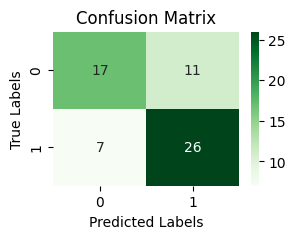

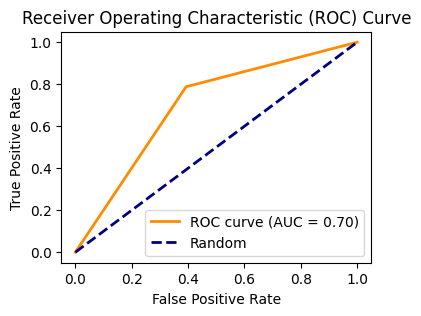

In [29]:
# decision tree (baseline)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(dt, X_test, y_test)

Precision: 0.76
Recall: 0.94
F1-score: 0.84
Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



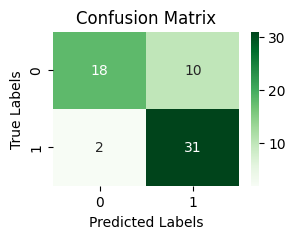

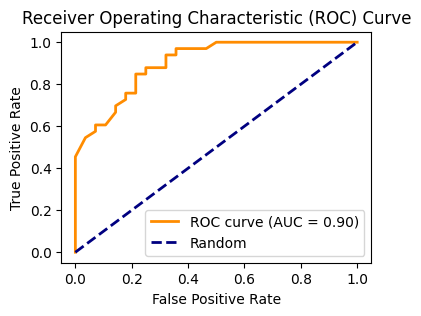

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(rf, X_test, y_test)

In [31]:
param_grid = {
    'n_estimators': list(range(100, 1000, 100)),
}
rf, params, f1 = param_tuning(rf, param_grid, X_train, y_train, 10)
print("Best params: ", params)

Best params:  {'n_estimators': 700}


Precision: 0.78
Recall: 0.94
F1-score: 0.85
Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.78        28
           1       0.78      0.94      0.85        33

    accuracy                           0.82        61
   macro avg       0.84      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



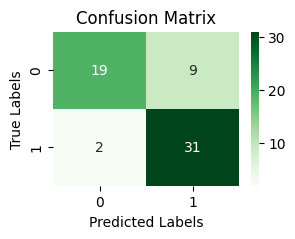

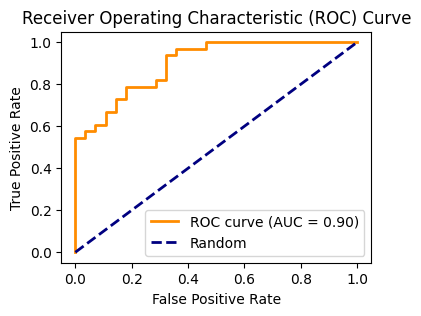

In [32]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(rf, X_test, y_test)

#### SHAP

SHAP (SHapley Additive exPlanations):

1. Calculate the SHAP values for your model and dataset.
2. Waterfall plot to show how each feature contributes to the final prediction for a single instance. This plot helps understand the impact of each feature on the model's decision.
3. Decision plot shows how the model's output changes as the value of a specific feature changes. This can help understand the non-linear interactions between features and the model's decision.
4. Summary plot provides an overview of feature importance, showing the impact of each feature across all instances in the dataset. This can help identify which features are most important for the model's decisions.
5. Force plots provide a detailed view of how each feature contributes to the model's output for a single instance. This can help understand the direction and magnitude of each feature's effect on the prediction.

In [34]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [35]:
pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
pred.reset_index(drop=True, inplace=True)
pred

y_test  y_pred
0        0       0
1        0       0
2        0       0
3        0       1
4        0       1
..     ...     ...
56       1       1
57       1       1
58       0       0
59       0       0
60       1       1

[61 rows x 2 columns]

In [36]:
# the base value indicates that, on average, the model predicts class 0 with a probability of 0.45929461 and
# class 1 with a probability of 0.54070539 over the background dataset (X_train)
explainer.expected_value

array([0.45672199, 0.54327801])

#### Summary

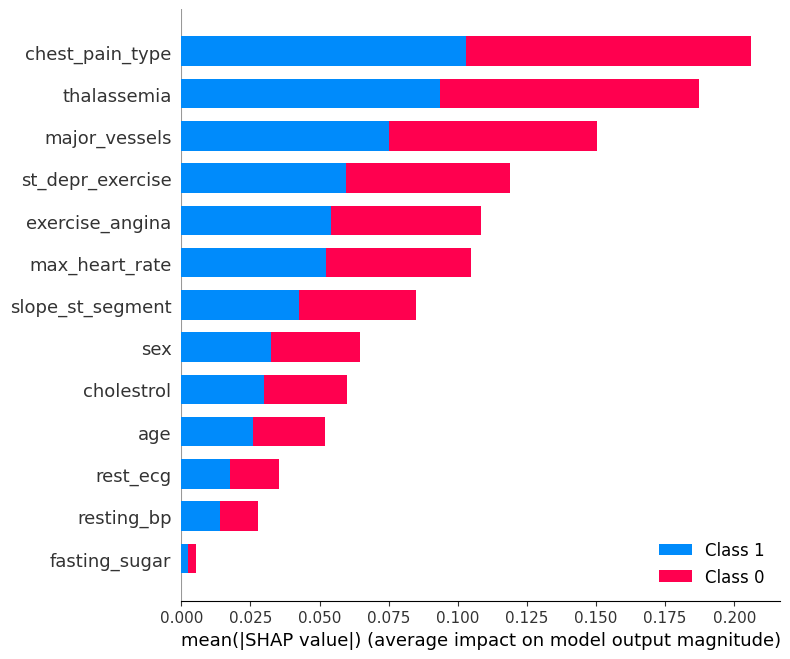

In [ ]:
# displays the features ranked by their importance, with the bars indicating the magnitude
# and direction of their impact on the model's predictions.
summary_plot(shap_values, X_test, plot_type='bar')

1. mod/high chest_pain_type leads to heart attack
2. low/mod thalessemia leads to heart attack
3. low major_vessels, st_depr_exercise, exercise_angina lead heart attack
4. mod/high slope_st_segment, max_heart_rate leads heart attack
5. there are high chance of females getting heart attack
6. how can low/mod cholestrol lead to more chances of heart attack
7. low/mod values lead to more chances of heart attack
8. high rest_ecg leads to heart attack
9. unclear about resting_bp, fasting_sugar

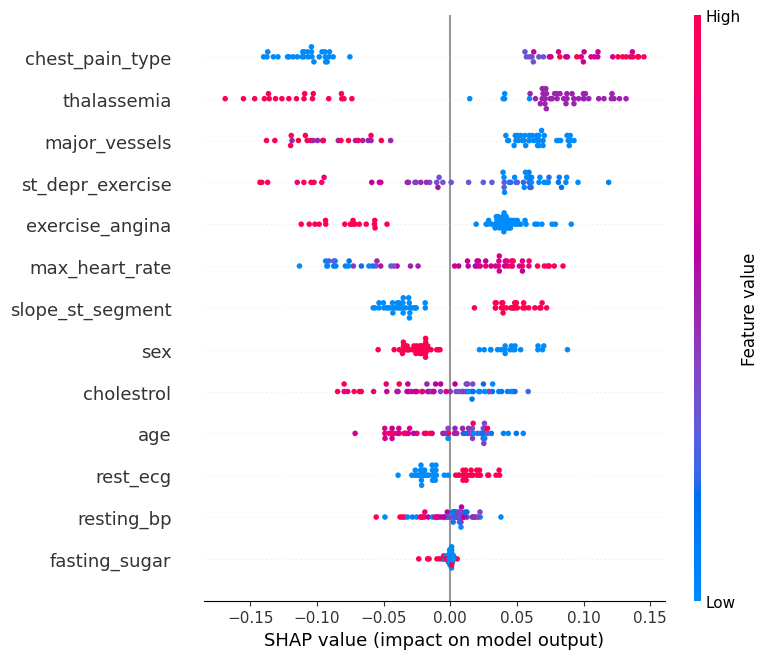

In [ ]:
# displays the summary_plot of the chances_of_heart_attack as “1”
summary_plot(shap_values[1], X_test)

#### Force

In [39]:
def force(row, output):
  shap.initjs()
  return shap.force_plot(explainer.expected_value[output], shap_values[output][row, :], X_test.iloc[row, :], matplotlib = True)

Correct Predictions

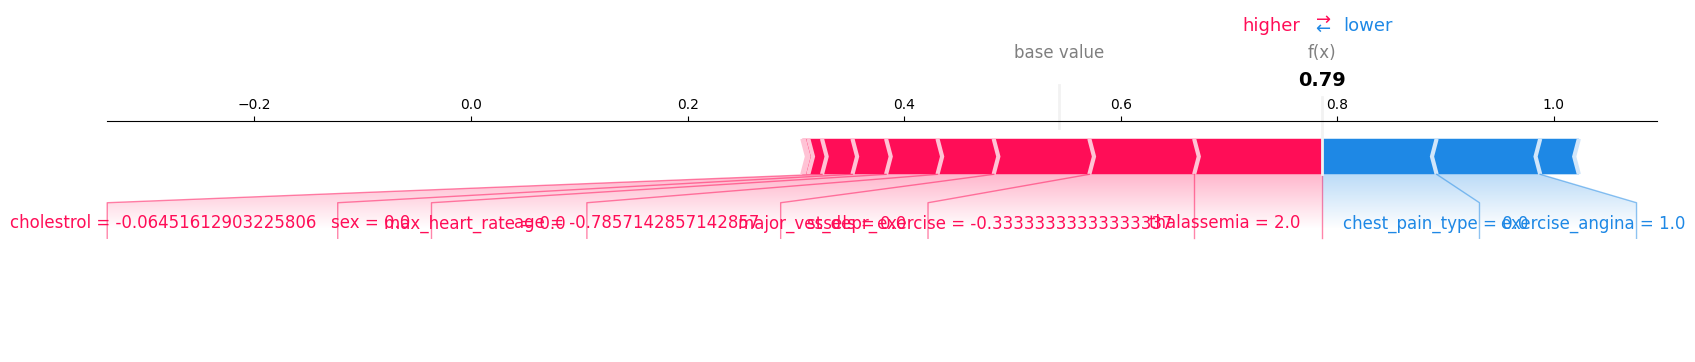

In [40]:
# correct output for 11th instance (predicted class = 1)
force(11, 1)

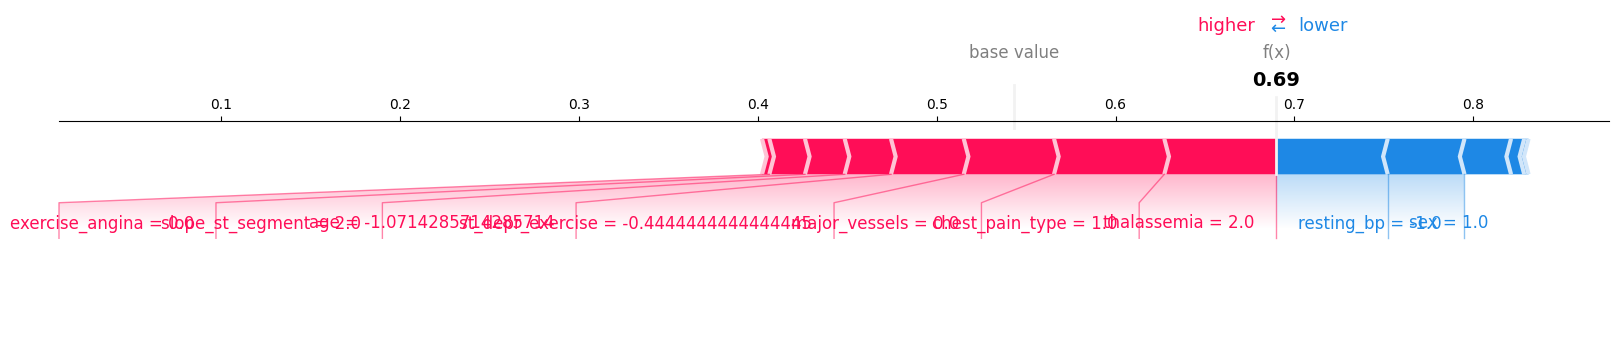

In [41]:
# correct output for 22nd instance (predicted class = 1)
force(22, 1)

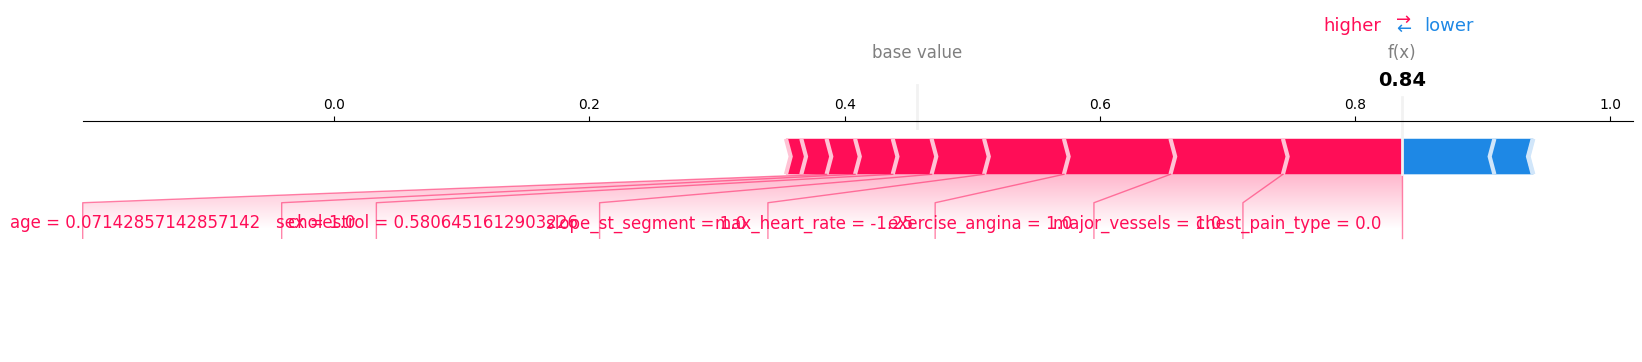

In [42]:
# correct output for 0th instance (predicted class = 0)
force(0, 0)

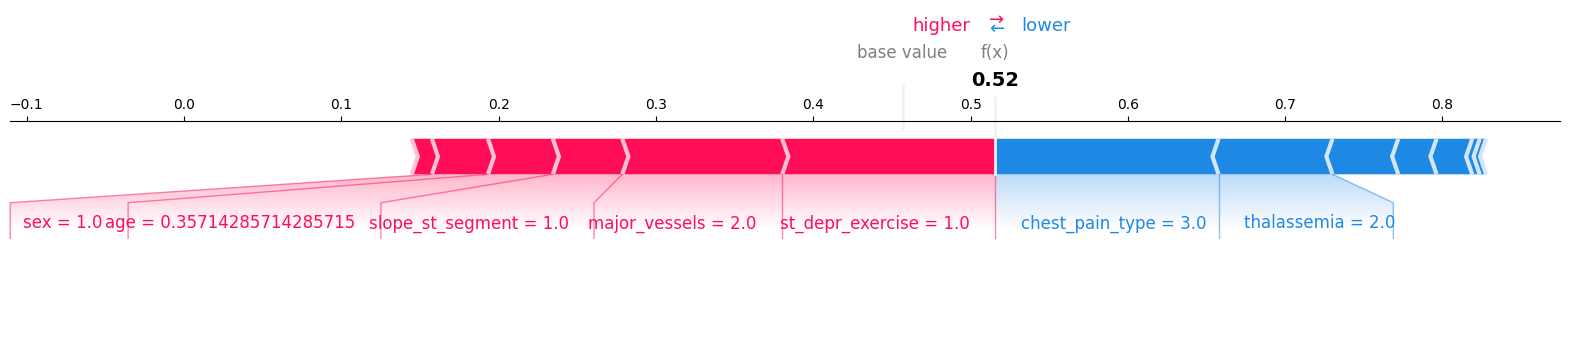

In [43]:
# correct output for 50th instance (predicted class = 0)
force(50, 0)

Wrong Predictions

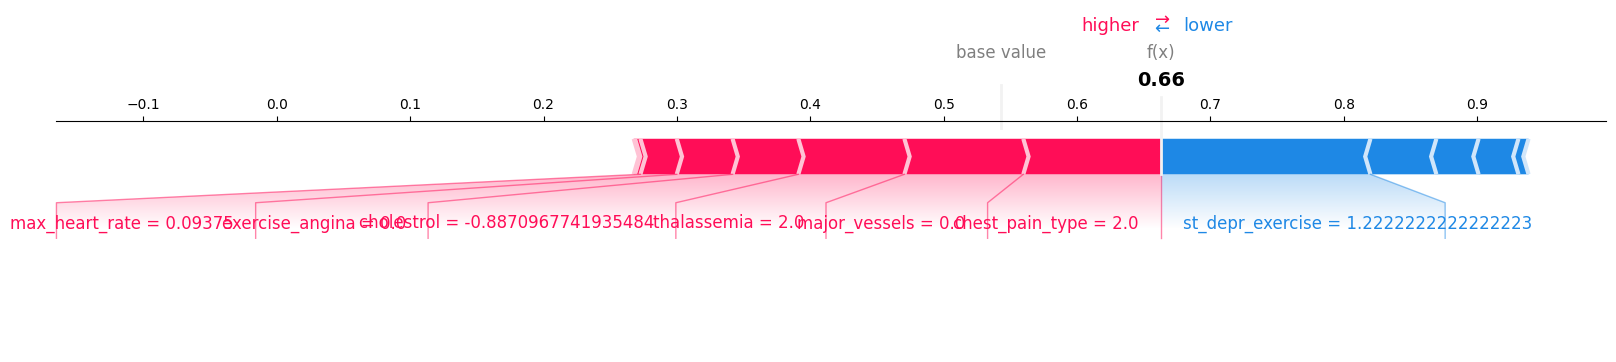

In [44]:
# wrong output for 3rd instance (predicted class = 1)
force(3, 1)

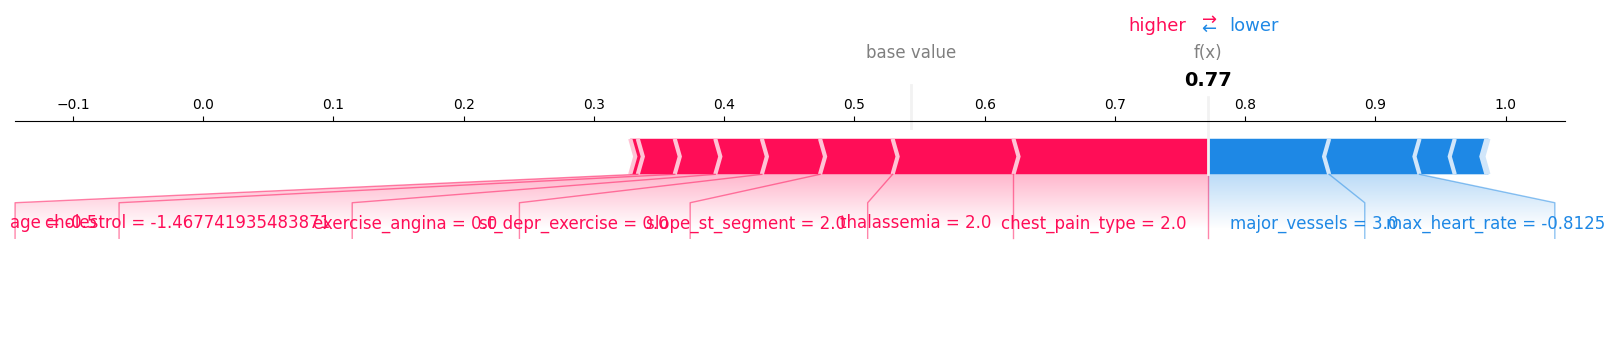

In [45]:
# wrong output for 20th instance (predicted class = 1)
force(20, 1)

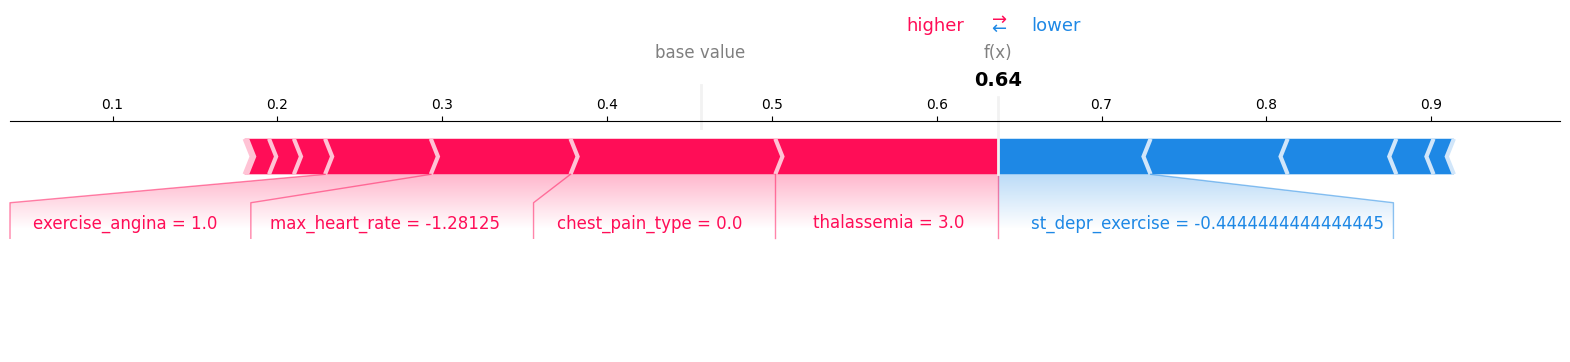

In [46]:
# wrong output for 10th instance (predicted class = 0)
force(10, 0)

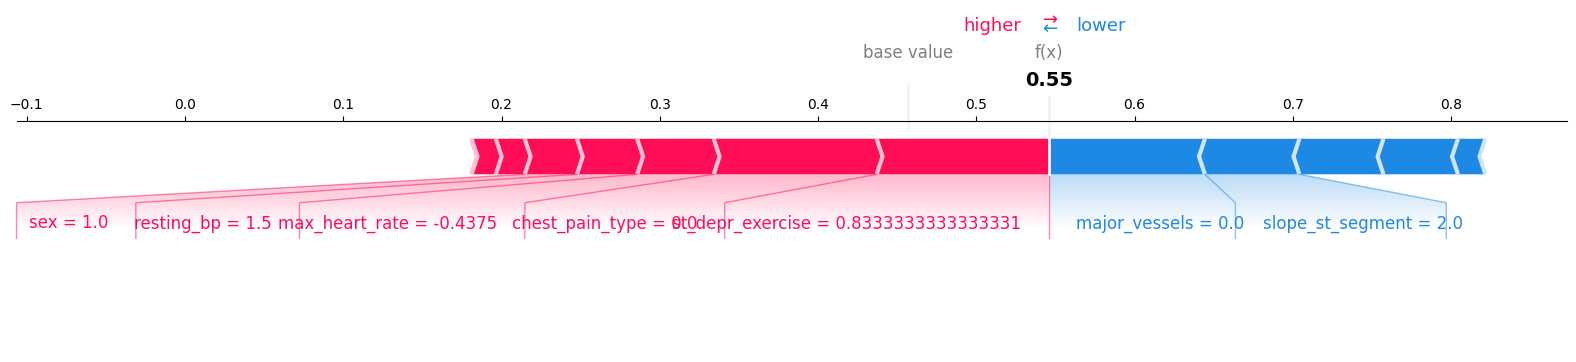

In [47]:
# wrong output for 29th instance (predicted class = 0)
force(29, 0)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:60, :], X_test.iloc[:60, :])

#### Dependence

In [87]:
def dependence(feature_name, interaction_feature=None, output=1):
  return dependence_plot(feature_name, shap_values[output], X_test, interaction_index=interaction_feature)

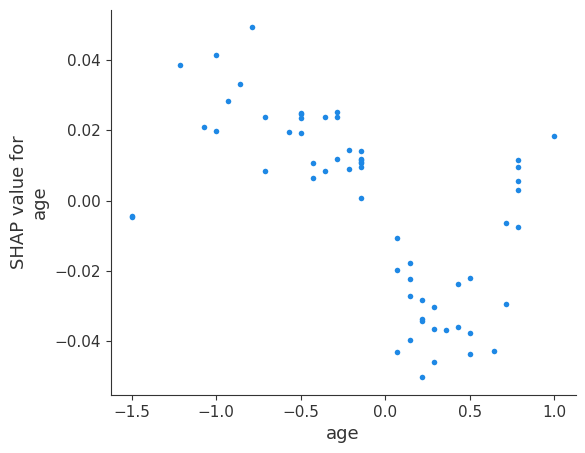

In [88]:
# less age i.e. young get impacted more
dependence("age")

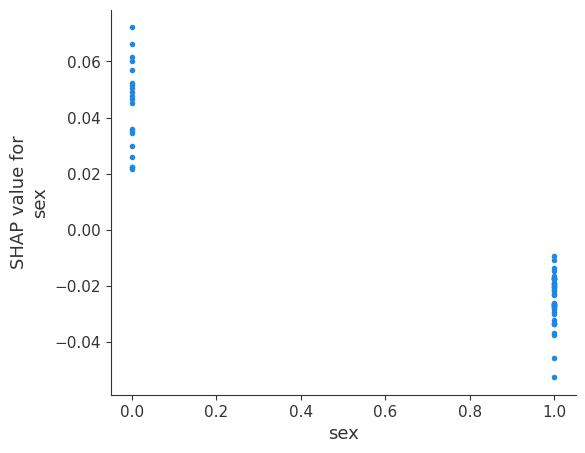

In [90]:
# Females (0) tend to suffer heart attack more
dependence("sex")

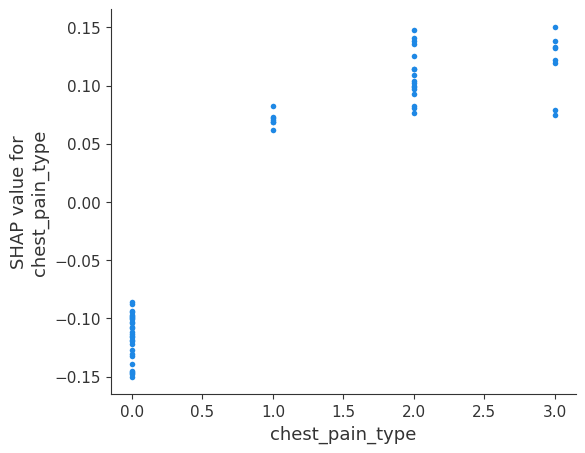

In [89]:
# Atypical angina and non-anginal chest_pain_type are concerning causes of heart attacks
dependence("chest_pain_type")

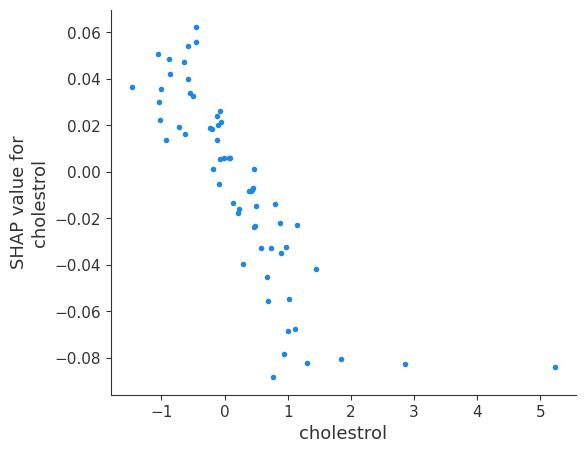

In [91]:
# low cholestrol -> high chances of a heart attack
dependence("cholestrol")

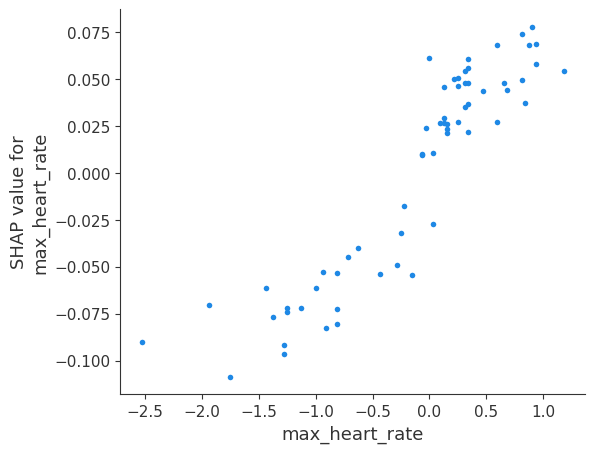

In [95]:
dependence("max_heart_rate")

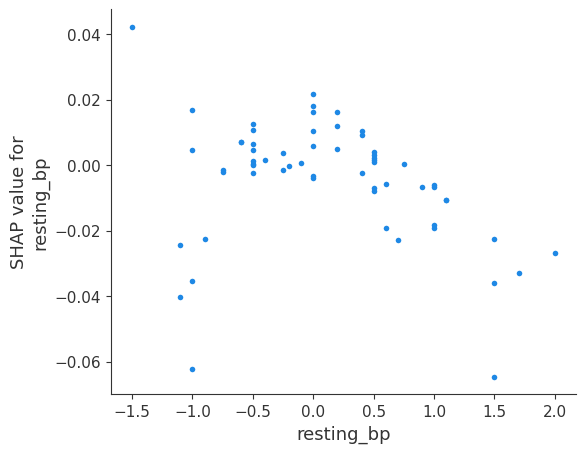

In [94]:
dependence("resting_bp")

#### Interaction

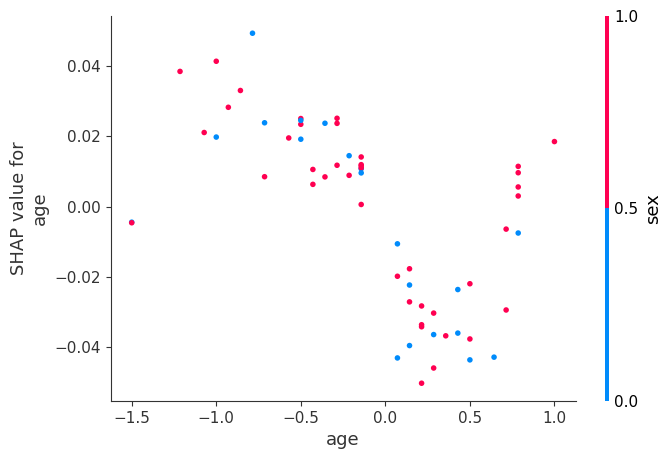

In [96]:
dependence("age", "sex")

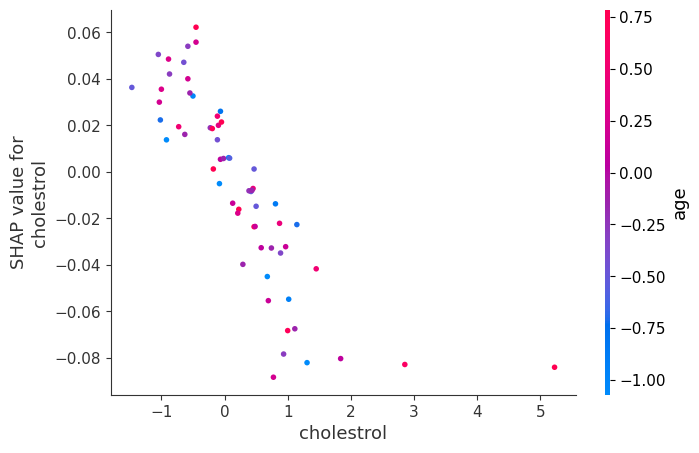

In [97]:
dependence("cholestrol", "age")

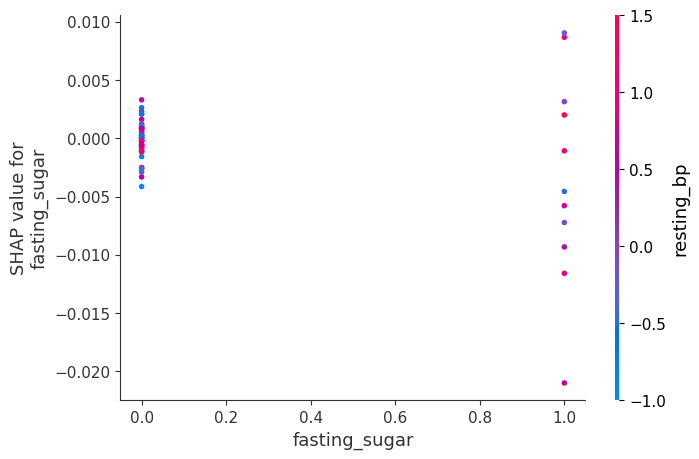

In [99]:
dependence("fasting_sugar", "resting_bp")

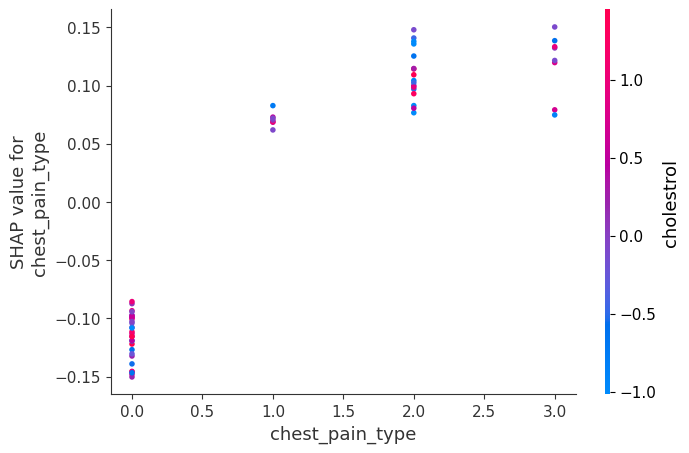

In [100]:
dependence("chest_pain_type", "cholestrol")

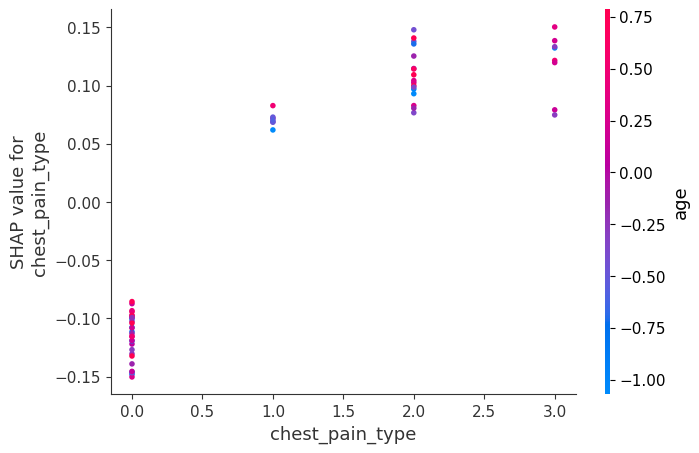

In [101]:
dependence("chest_pain_type", "age")

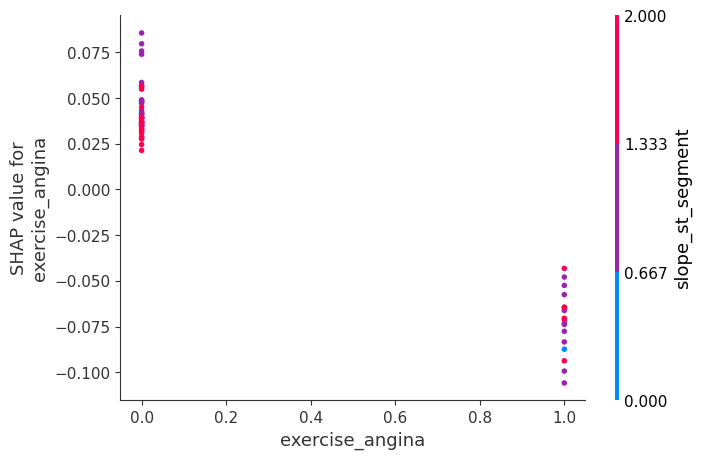

In [102]:
dependence("exercise_angina", "slope_st_segment")

#### Decision

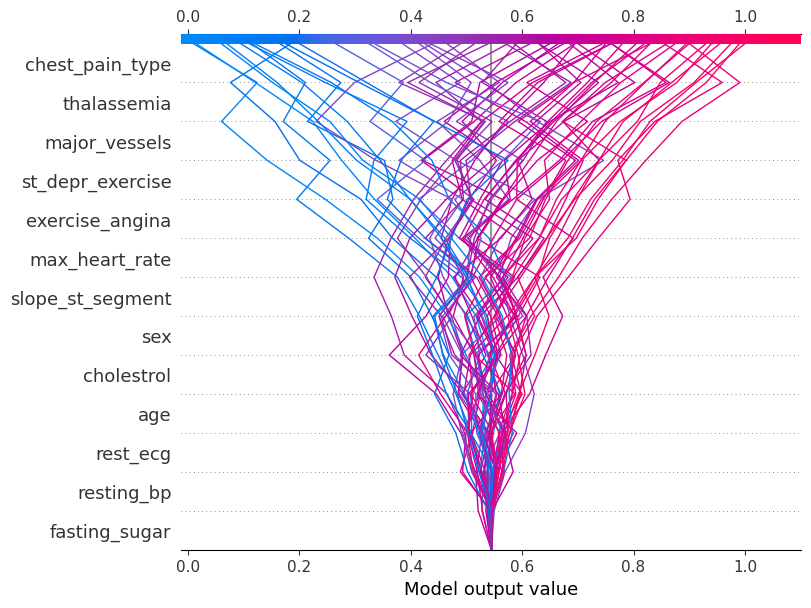

In [ ]:
# The target label “1” decision plot is tilted towards “1”.
decision_plot(explainer.expected_value[1], shap_values[1], X_test)

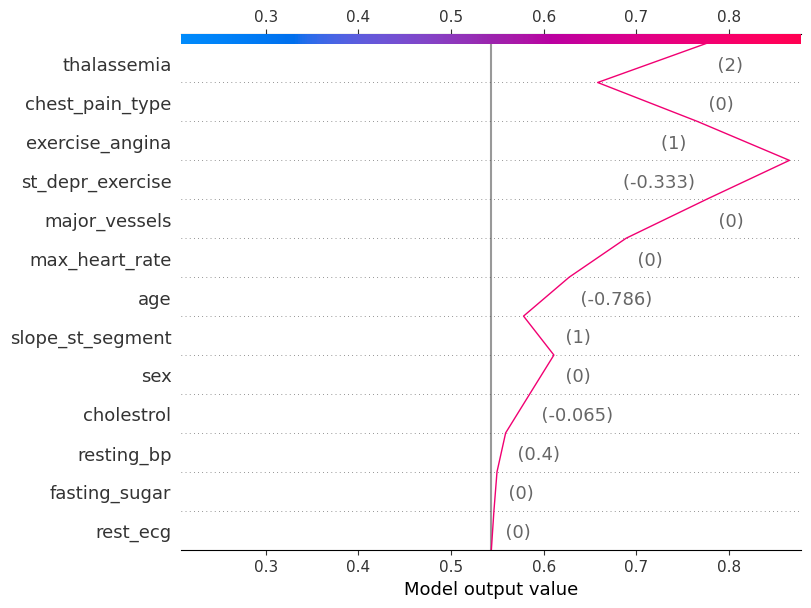

In [82]:
# right output = "1", instance = 11
decision_plot(explainer.expected_value[1], shap_values[1][11, :], X_test.iloc[11])

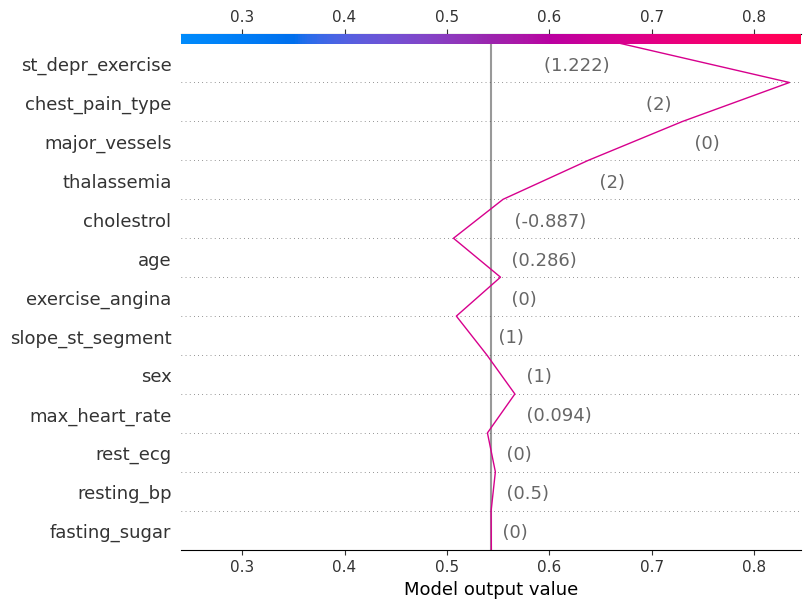

In [83]:
# wrong output = "1" expected = "0", instance = 3
decision_plot(explainer.expected_value[1], shap_values[1][3, :], X_test.iloc[3])

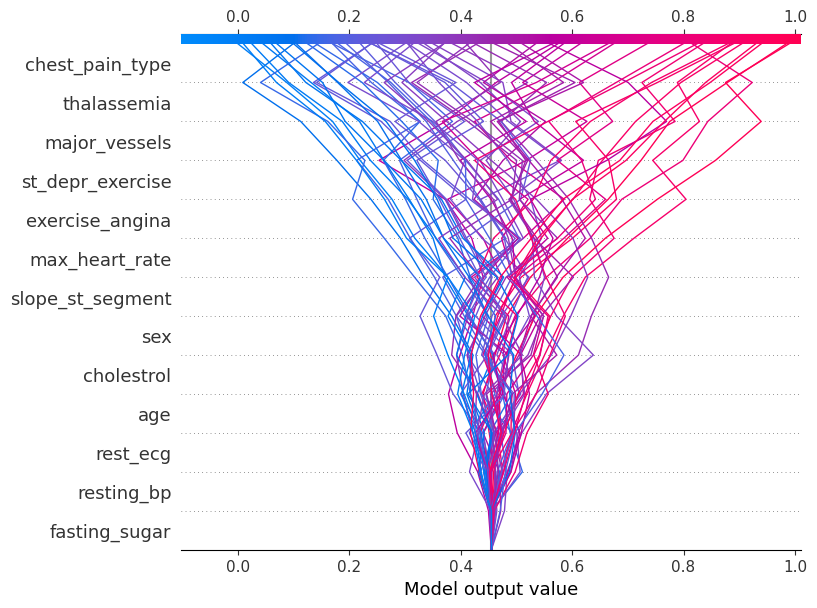

In [ ]:
# The target label “0” decision plot is tilted towards “0”.
decision_plot(explainer.expected_value[0], shap_values[0], X_test)

#### Waterfall

In [ ]:
explanation = explainer(X_test)

In [ ]:
def waterfall(id_to_explain, output_to_explain):
  return shap.plots.waterfall(explanation[id_to_explain, :, output_to_explain])

Correct Predictions

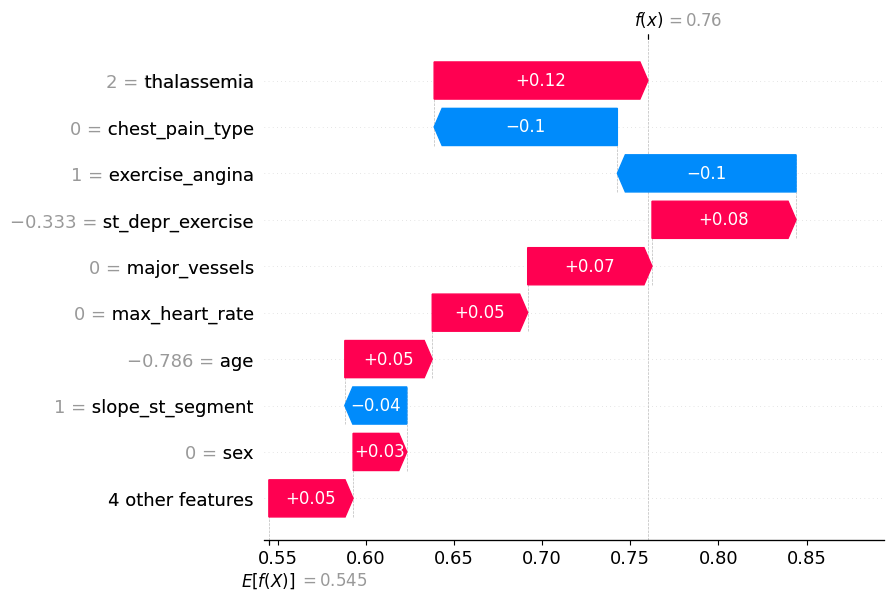

In [ ]:
# correct output for 11th instance (predicted class = 1)
waterfall(11, 1)

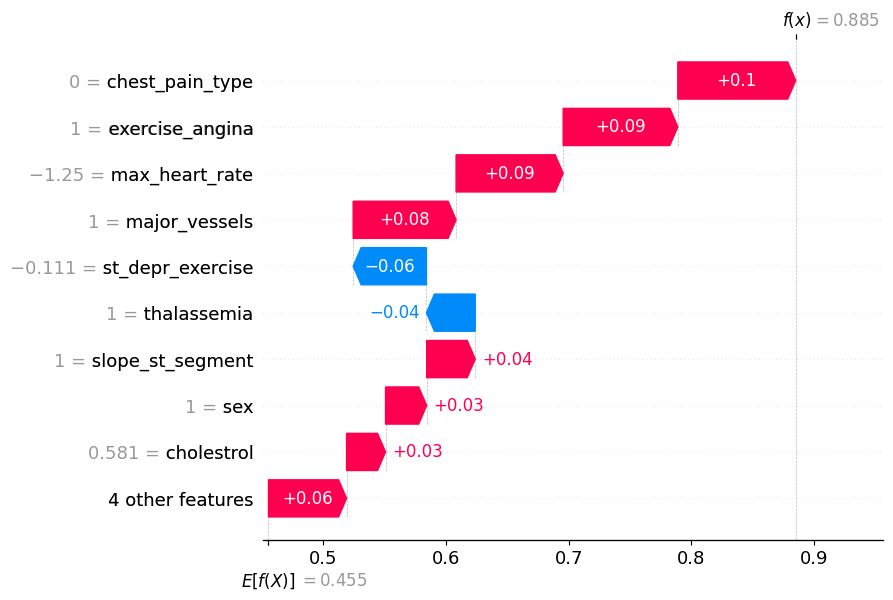

In [ ]:
# correct output for 0th instance (predicted class = 0)
waterfall(0, 0)

Wrong Predictions

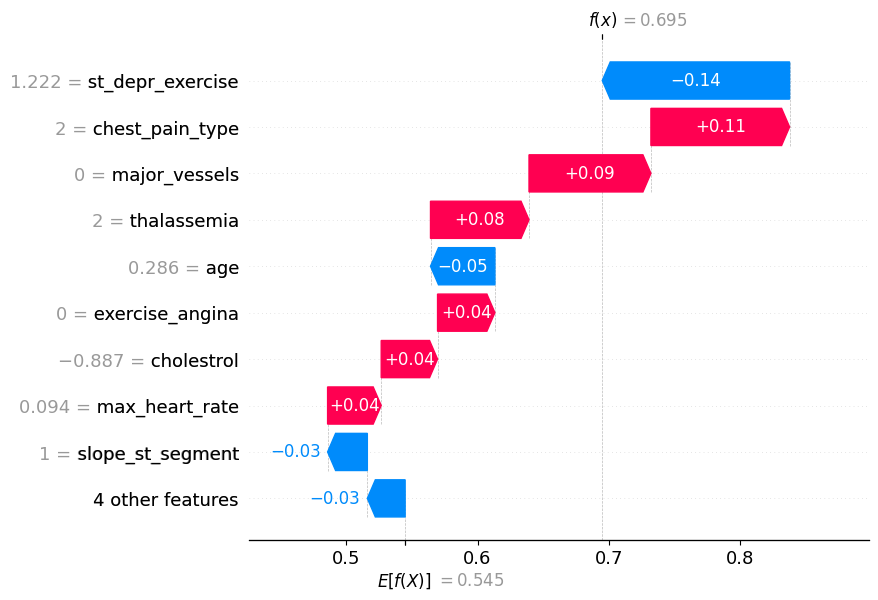

In [ ]:
# wrong output for 3rd instance (predicted class = 1)
waterfall(3, 1)

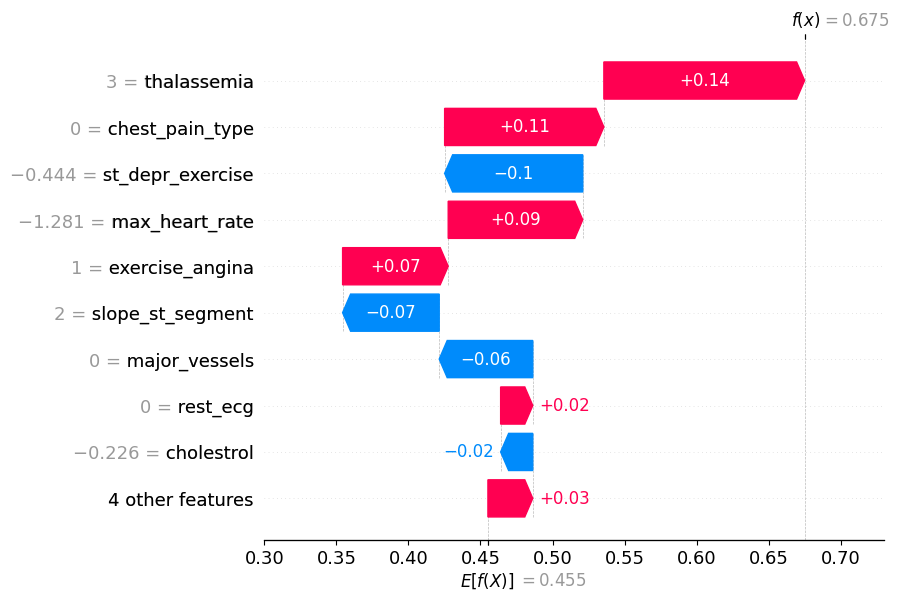

In [ ]:
# wrong output for 10th instance (predicted class = 0)
waterfall(10, 0)